#Importing necessary modules
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve,
confusion_matrix
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn

In [2]:
#Importing necessary modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib #
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn

In [3]:
#Printing our packages version
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

Numpy: 1.19.5
Pandas: 0.22.0
matplotlib: 2.1.1
seaborn: 0.8.1
Scikit-Learn: 0.21.3
MLFlow: 1.13.1


In [4]:
#Importing database
data_path = "data/creditcard.csv"
df = pd.read_csv(data_path)
df = df.drop("Time", axis=1)

In [5]:
#printing the 5 first elements
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
#split the normal points and the anomalies and print their respective shapes
normal = df[df.Class == 0].sample(frac=0.5,random_state=2021).reset_index(drop=True)
anomaly = df[df.Class == 1]
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


In [7]:
#split the normal and anomaly sets into train-test-validate subsets
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2021)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2021)
normal_train, normal_validate = train_test_split(normal_train,test_size = 0.25, random_state = 2021)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2021)

In [8]:
#concatenate the normal and anomalies
xtrain = pd.concat((normal_train, anomaly_train))
xtest = pd.concat((normal_test, anomaly_test))
xval = pd.concat((normal_validate, anomaly_validate))
ytrain = np.array(xtrain["Class"])
ytest = np.array(xtest["Class"])
yval = np.array(xval["Class"])
xtrain = xtrain.drop("Class", axis=1)
xtest = xtest.drop("Class", axis=1)
xval = xval.drop("Class", axis=1)

In [9]:
#print train, test and validation shape
print("Training sets shape:\nxtrain: {} \nytrain:{}".format(xtrain.shape, ytrain.shape))
print("\nTesting sets shape:\nxtest: {} \nytest:{}".format(xtest.shape, ytest.shape))
print("\nValidation sets shape:\nxval : {} \nyval: {}".format(xval.shape, yval.shape))

Training sets shape:
xtrain: (85588, 29) 
ytrain:(85588,)

Testing sets shape:
xtest: (28531, 29) 
ytest:(28531,)

Validation sets shape:
xval : (28531, 29) 
yval: (28531,)


In [10]:
#scale the data using scikit-learn’s standard scaler
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)
xval = scaler.transform(xval)

In [12]:
#Training and evaluating with Mlflow
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=2021)
mlflow.set_experiment("sklearn_creditcard_broad_search")
logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores= []
    for train, test in kfold.split(xval, yval):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            class_weights= {
            0: 1,
            1: weight
            }
            sk_model = LogisticRegression(random_state=None, max_iter=400,solver='newton-cg',
                                          class_weight=class_weights).fit(xval[train],yval[train])
            for h in range(40): print('-', end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(xval[train],yval[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(xval[test],yval[test])
            preds = sk_model.predict(xval[test])
            mlflow.log_metric("eval_acc", eval_acc)
            for h in range(40): print('-', end="")
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(xval[train],yval[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(xval[test],yval[test])
            preds = sk_model.predict(xval[test])
            mlflow.log_metric("eval_acc", eval_acc)
            try:
                auc_score = roc_auc_score(yval[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score,eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, xval[test],yval[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
        print("\nAverages: ")
        print("Accuracy: ", np.mean(accuracies))
        print("AUC: ", np.mean(auc_scores))
        print("Best: ")
        print("Accuracy: ", np.max(accuracies))
        print("AUC: ", np.max(auc_scores))


----------------------------------------
fold 1
Anomaly Weight: 1
----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.7941176470588236
eval_acc: 0.9987734361310671

Averages: 
Accuracy:  0.9987734361310671
AUC:  0.7941176470588236
Best: 
Accuracy:  0.9987734361310671
AUC:  0.7941176470588236
----------------------------------------
fold 2
Anomaly Weight: 1
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.863196532531508
eval_acc: 0.9980722046968104

Averages: 
Accuracy:  0.9984228204139387
AUC:  0.8286570897951657
Best: 
Accuracy:  0.9987734361310671
AUC:  0.863196532531508
----------------------------------------
fold 3
Anomaly Weight: 1
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.9499120647203658
eval_acc: 0.9994742376445847

Averages: 
Accuracy:  0.9987732928241541
AUC:  0.8690754147702324
Best: 
Accuracy:  0.9994742376445847
AUC:  0.9499120647203658
----------------------------------------
fold 4
Anomaly Weig

In [22]:
#Showing mlflow results in picture
import matplotlib.image as mpimg
analysis_result=mpimg.imread('mlflow.JPG')

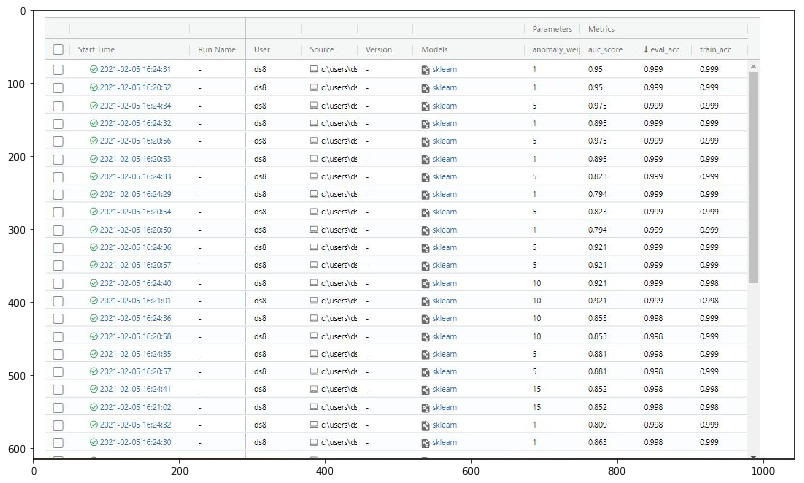

In [25]:
fig = plt.figure(figsize = (30,15))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(analysis_result)

In [28]:
#Loading a logged model
loaded_model = mlflow.sklearn.load_model("runs:/d21eedb1449242dea38dd660a9351a07/anom_weight_1_fold_3")

In [30]:
#scoring on test set
loaded_model.score(xtest, ytest)

0.9987732641687989

In [32]:
#Scaling new data 
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]
normal_train, normal_test = train_test_split(normal,test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Class"],axis=1))


StandardScaler(copy=True, with_mean=True, with_std=True)

In [42]:
#Using deployed model to make prevision
import subprocess
import json
scaled_selection = scaler.transform(df.iloc[:80].drop(["Class"], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient="split")
proc = subprocess.run(["curl", "-X", "POST", "-H","Content-Type:application/json; format=pandas-split","--data", input_json,
                       "http://kubernetes.docker.internal:1235/invocations"],stdout=subprocess.PIPE, encoding='utf-8')
output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
from sklearn.metrics import accuracy_score
y_true = df.iloc[:80].Class
preds = preds.T
eval_acc = accuracy_score(y_true, preds)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 1.0
Eval AUC 0.5


c:\users\ds8\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
np.shape(y_true),np.shape(preds)

((80,), (80, 1))